# Выберем группу Вконтакте и импортируем из нее 10 000 участников

#### У каждого импортированного участника присутствуют следующие параметры:
* id
* city
* bdate
* sex
* country

In [121]:
# Required libraries

import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import pickle
import numpy as np
import random


In [2]:
# Required urls to access vk api

group_api_url = 'https://api.vk.com/method/groups.getMembers?group_id='
id_api_url = 'https://api.vk.com/method/friends.get?user_id='
fields = '&fields=sex,bdate,city,country'
count = '&count=1000'
offset = '&offset='

In [3]:
# Function which takes community id in and returns list of it's members. Every member got id, sex, city and etc.

def extract_members(group_id):

    list_of_members = []
    
    for offset_number in range(0, 10000, 1000):
        
        url = group_api_url + str(group_id) + offset + str(offset_number) + count + fields
        json_response = requests.get(url).json()
        users = json_response['response']['users']
        list_of_members += users
        
    return list_of_members

In [4]:
# Taking habrahabr community for example, id - 20629724

group_members = extract_members(20629724)

In [38]:
# Example of member's profile

group_members[228]

{'bdate': '12.6.1988',
 'city': 2,
 'country': 1,
 'first_name': 'Андрей',
 'last_name': 'Мальцев',
 'sex': 2,
 'uid': 4169}

In [36]:
import pickle
output = open('group_members.pkl', 'wb')
pickle.dump(group_members, output)
output.close()

In [82]:
with open('group_members.pkl', 'rb') as f:
    group_members = pickle.load(f)

# Теперь сделаем список ребер:
* Среди импортированных участников для каждого ищем друга среди этой группы


In [85]:
# List of community members id's

members_ids = []

for member in group_members:
    members_ids.append(member['uid'])

In [23]:
# Function takes in user id and returns list of id's of people which are his friends and community members at the 
# same time

def user_friends_list(user_id):
    
    url = id_api_url + str(user_id)
    
    try:
        json_response = requests.get(url).json()
    except requests.exceptions.RequestException: 
        return []
    
    if 'error' in json_response.keys():
        return []
    
    friends_inside_community_list = list(set(json_response['response']).intersection(members_ids))
    return friends_inside_community_list

In [ ]:
# Создаем файл, в нем список ребер: пары вершина - вершина 

f1 = open('friends_inside_1.txt', 'w')

for member_id in members_ids:
    
    a = user_friends_list(member_id)
    
    if len(a) != 0:
        
        for friend_id in a:
            f1.write('%d' % member_id)
            f1.write(' ')
            f1.write('%d' % friend_id)
            f1.write('\n')

f1.close()
f2.close()

# Кладем граф в структуру данных библиотеки networkx

In [86]:
# Открываем наш граф в networkx

import networkx as nx

G1 = nx.read_edgelist('friends_inside_1.txt')

In [87]:
# Основные показатели графа

print('Число вершин:', len(list(G1.nodes())))
print('Число ребер:', len(list(G1.edges())))
print('Как видно вершин всего 7835, а не 10000, это связано с тем что много профилей - удаленные')

Число вершин: 7835
Число ребер: 25483
Как видно вершин всего 7835, а не 10000, это связано с тем что много профилей - удаленные


# Выявление сообществ

# 1. k-cores

A k-core is a maximal subgraph that contains nodes of degree k or more.

In [88]:
k_cores_size = []

for i in range(1, 15):
    k_cores_size.append(len(nx.k_core(G1, i).nodes()))

In [89]:
for i, n in enumerate(k_cores_size):
    print('Количество вершин в %s-core:' % (i+1), n)

Количество вершин в 1-core: 7835
Количество вершин в 2-core: 6099
Количество вершин в 3-core: 4628
Количество вершин в 4-core: 3276
Количество вершин в 5-core: 2231
Количество вершин в 6-core: 1491
Количество вершин в 7-core: 864
Количество вершин в 8-core: 567
Количество вершин в 9-core: 280
Количество вершин в 10-core: 136
Количество вершин в 11-core: 78
Количество вершин в 12-core: 63
Количество вершин в 13-core: 53
Количество вершин в 14-core: 0


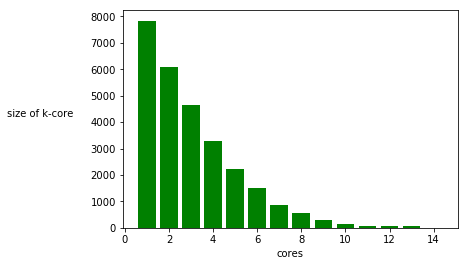

In [90]:
k_dict = {}

for i, n in enumerate(k_cores_size):
    k_dict[n] = i+1

plt.bar(list(k_dict.values()), list(k_dict.keys()), color='g')
plt.xlabel('cores')
plt.ylabel('size of k-core',rotation=0, labelpad=50)
plt.show()

### Посмотрим на выявленное сообщество при k = 13 отдельно

In [66]:
k_core_users = []

k_core_nodes = list(map(int, nx.k_core(G1, 13).nodes()))

for user in group_members:
    
    if user['uid'] in k_core_nodes:
        
        k_core_users.append(user)

In [94]:
cities = []

for user in k_core_users:
    cities.append(user['city'])

In [104]:
from collections import Counter
Counter(cities)

Counter({0: 7,
         1: 10,
         2: 30,
         133: 1,
         378: 1,
         458: 1,
         483: 1,
         2182: 1,
         1925340: 1})

Как видно большинство (30 из 53) человек из Питера (код города в vk - 2)

### Теперь посмотрим на время сложности работы алгоритма в зависимости от k

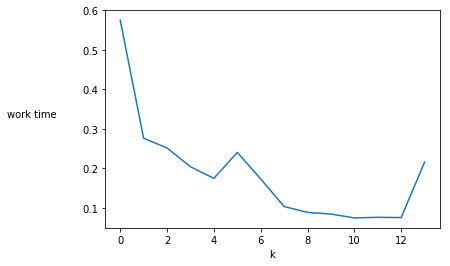

In [188]:
k_time = []

for i in range(1, 15):
    start_time = time.time()
    nx.k_core(G1, i)
    k_time.append(time.time() - start_time)
    
plt.plot(k_time)
plt.ylabel('work time',rotation=0, labelpad=50)
plt.xlabel('k')
plt.show()

### Теперь посмотрим на время работы алгоритма в зависимости от размера графа

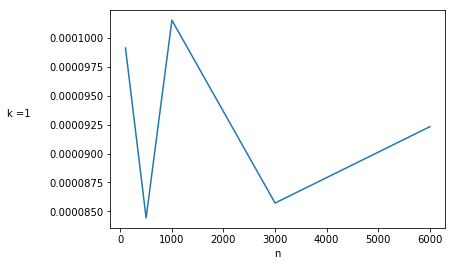

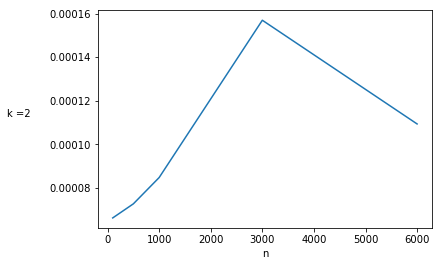

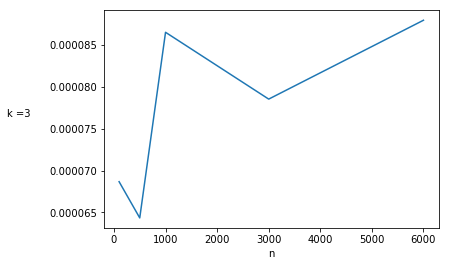

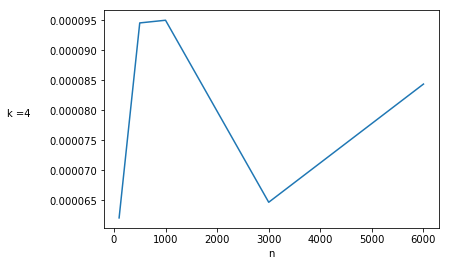

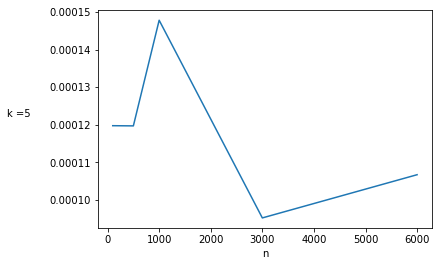

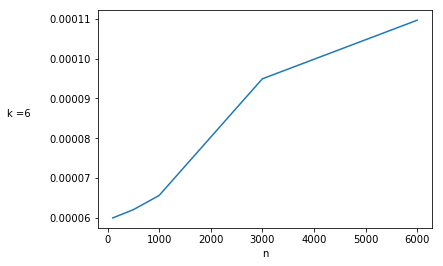

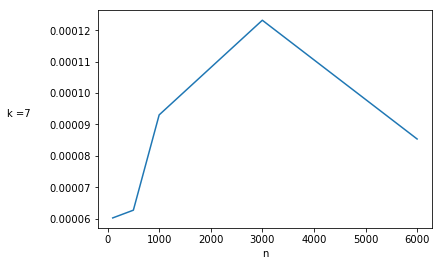

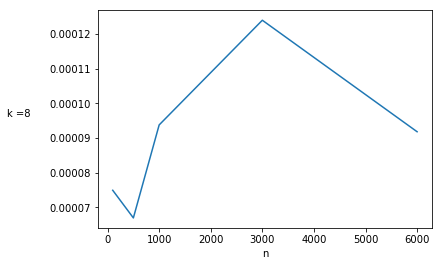

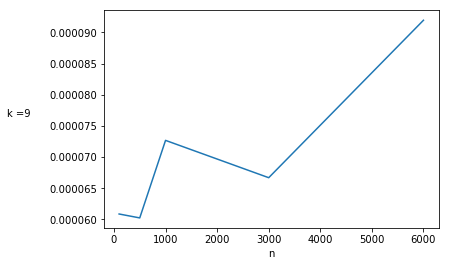

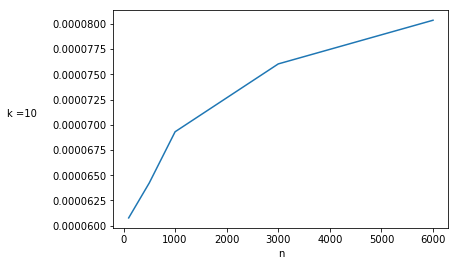

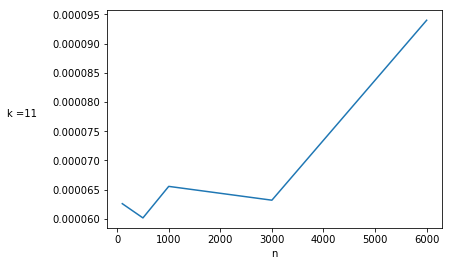

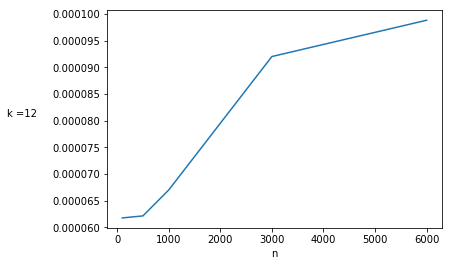

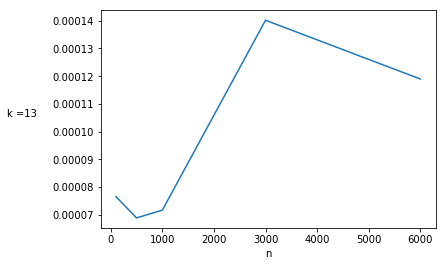

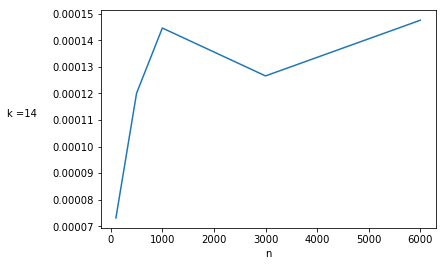

In [192]:
n_subgraph = [100, 500, 1000, 3000, 6000]
node_list = list(map(int, G1.nodes()))

for k in range(1, 15):
    
    time_list = []
    
    for n in n_subgraph:
        
        avg_time = 0
        
        for i in range(1000):
            x = random.sample(node_list, n)
            H = G1.subgraph(x)

            start_time = time.time()
            nx.k_core(H, k)
            avg_time += time.time() - start_time
        
        time_list.append(avg_time / 1000)
        
    plt.plot(n_subgraph, time_list)
    plt.ylabel('k =%s' %k, rotation=0, labelpad=30)
    plt.xlabel('n')
    plt.show()

# 2. Louvain Method for community detection

Сразу применяем метод и смотрим на время работы алгоритма в зависимости от размера графа.

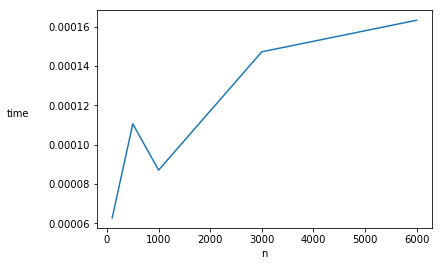

In [194]:
# Применим известный метод, для каждого сообщества - свой цвет

import community

n_subgraph = [100, 500, 1000, 3000, 6000]
node_list = list(map(int, G1.nodes()))

time_list = []

for n in n_subgraph:

    avg_time = 0

    for i in range(5000):
        x = random.sample(node_list, n)
        H = G1.subgraph(x)

        start_time = time.time()
        community.best_partition(H)
        avg_time += time.time() - start_time

    time_list.append(avg_time / 1000)

plt.plot(n_subgraph, time_list)
plt.ylabel('time', rotation=0, labelpad=30)
plt.xlabel('n')
plt.show()
